# Exploring Feature Importance and Feature Interaction

This notebook explores ideas around Feature Importance and Feature Interaction by generating a synthetic data set with fetures of different feature importance and interactivity. Its purpose is to validate using methods of feature importance and to explore methods of discovering features which have strong interaction with other features.

A lot of these ideas come from the excellent 'fastai' course 'Introduction to Machine Learning for Coders' http://course18.fast.ai/ml

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math

First create features from different random distributions. Features were designed to be roughly normalised with a range of [-1, 1]. Different distributions were used to see if this had an effect on feature importance.

In [2]:
n_samples = 10000

In [3]:
x = {f'x{i}': np.random.uniform(-1, 1, n_samples) for i in range(1, 21)}

Example of one of the uniformly distributed features

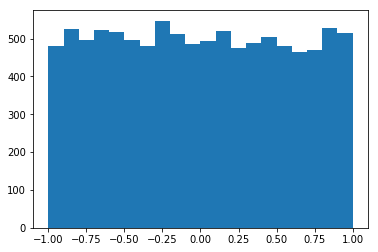

In [4]:
plt.hist(x['x1'], bins=20)
plt.show()

Now we create our independent variable 'y'. Note the magnitudes of the coefficients these are indiciative of how 'important' each feature is to predicting the dependent variable

In [5]:
# Start with our strongest feature we want to see if we can find later x2-x1
y = x['x1'] + x['x11']
y += 2*x['x2'] + 2*x['x12']
y += 3*x['x3'] + 3*x['x13']
y += 4*x['x4'] + 4*x['x14']
y += 5*x['x5'] + 5*x['x15']
y += 6*x['x6'] + 6*x['x16']
y += 7*x['x7'] + 7*x['x17']
y += 8*x['x8'] + 8*x['x18']
y += 9*x['x9'] + 9*x['x19']
y += 0*x['x10'] + 0*x['x20']

# Add a bias
y += 100

# Add some random noise
y += np.random.normal(0, 1, y.shape)

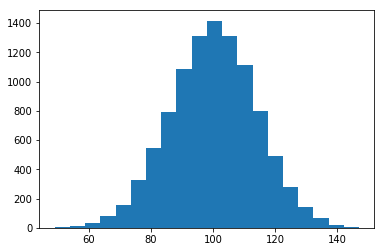

In [6]:
plt.hist(y, bins=20)
plt.show()

In [7]:
y.min(), y.max()

(49.103869332278862, 146.96935739096696)

stack all of our independent variables x1, x2, ..., x10 into a pd data frame. So that we can input them into our model

In [8]:
x = pd.DataFrame(x).sample(frac=1.0, axis=1)

In [9]:
x.head()

,x5,x17,x4,x11,x1,x7,x2,x20,x6,x10,x14,x16,x19,x18,x8,x13,x15,x12,x9,x3
0,0.518083,0.693310,-0.003208,0.349293,-0.779954,-0.075674,-0.706184,-0.224453,0.904443,0.963249,-0.698611,-0.548869,0.021443,-0.902659,0.884412,-0.727568,-0.646115,-0.080247,-0.123357,0.672529
1,0.908806,-0.688318,-0.001827,-0.264764,0.390311,-0.690021,0.582232,0.587077,-0.677736,-0.254752,0.005309,0.096591,0.495403,-0.876956,0.907722,-0.752740,0.831761,-0.052577,-0.438134,-0.549114
2,-0.950597,0.889743,-0.304298,-0.449903,-0.444217,-0.664889,0.819041,0.253700,-0.239804,0.507929,-0.898082,0.700114,-0.153918,0.837453,-0.102619,0.119751,-0.337819,0.108287,-0.568088,-0.159146
3,0.206601,-0.180585,-0.604376,-0.565046,0.906402,-0.938988,-0.887834,-0.004634,-0.100210,0.516289,0.499385,-0.585651,-0.547363,0.650880,0.173404,-0.007164,0.413953,0.738910,0.879467,-0.509059
4,0.528141,-0.141617,0.189632,-0.630879,0.820308,0.460585,-0.937833,-0.799150,0.050300,-0.684584,-0.162709,-0.708892,-0.051065,0.993913,-0.935680,0.723668,0.990327,-0.124565,-0.214211,-0.045806


In [10]:
x.shape

(10000, 20)

Split dataset and labels into train, validate and test

In [11]:
x_trn, x_val, x_test = x.iloc[:8000, :], x.iloc[8000:9000, :], x.iloc[9000:, :]
y_trn, y_val, y_test = y[:8000], y[8000:9000], y[9000:]

In [12]:
x_trn.shape, x_val.shape, x_test.shape

((8000, 20), (1000, 20), (1000, 20))

In [13]:
y_trn.shape, y_val.shape, y_test.shape

((8000,), (1000,), (1000,))

Train a model

In [14]:
m = RandomForestRegressor(n_estimators=200, max_features=0.5).fit(x_trn, y_trn)

Score and evaluate the model

In [15]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, pass_back=False):
    res = [rmse(m.predict(x_trn), y_trn), rmse(m.predict(x_val), y_val),
                m.score(x_trn, y_trn), m.score(x_val, y_val)]
    print(f'Train RMSE: {round(res[0], 3)}')
    print(f'Validation RMSE: {round(res[1], 3)}')
    print(f'Train R-Squared: {round(res[2], 3)}')
    print(f'Validation R-Squared: {round(res[3], 3)}')
    if pass_back:
        return res

In [16]:
scores = print_score(m, pass_back=True)
val_rmse = scores[1]

Train RMSE: 2.283
Validation RMSE: 5.95
Train R-Squared: 0.973
Validation R-Squared: 0.813


Plot labels of training data vs predictions of training data

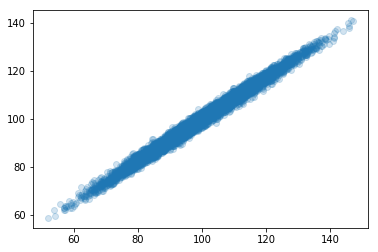

In [17]:
plt.scatter(y_trn, m.predict(x_trn), alpha=0.2)
plt.show()

Plot predictions of validation data vs true labels

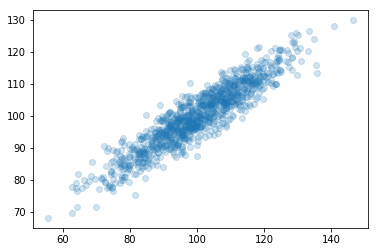

In [18]:
plt.scatter(y_val, m.predict(x_val), alpha=0.2)
plt.show()

Evaluate Feature importance
Using the model trained on all features. For each feature, take the validation set as it us but shuffle the order of the values in that feature one at a time. Make predictions on this input with one feature shuffled and look at the error and how much effect shuffling the values in this one column had on the error score.

In [21]:
df_importance = pd.DataFrame()
for col in x_val.columns:
    x_shuffle = x_val.copy()
    shuffled_column = x_shuffle[col].values
    np.random.shuffle(shuffled_column)
    x_shuffle[col] = shuffled_column
    rmse_score = rmse(y_val, m.predict(x_shuffle))
    row = {}
    row['col'] = col
    row['score'] = rmse_score
    df_importance = df_importance.append(row, ignore_index=True)

df_importance = df_importance.sort_values(by='score')

In [22]:
top_ten_fi_vars = df_importance.reset_index(drop=True).iloc[:20, 0].values

df_importance['error_diff'] = df_importance['score'] - val_rmse

error_diffs = {row['col']: row['error_diff'] for i, row in df_importance.iterrows()}

df_importance = df_importance.sort_values(by='error_diff', ascending=False)
df_importance.head(10)

,col,score,error_diff
18,x9,9.041591,3.091812
12,x19,8.496055,2.546276
14,x8,8.242561,2.292782
13,x18,8.172717,2.222938
1,x17,7.639553,1.689774
5,x7,7.568362,1.618583
11,x16,6.946172,0.996393
8,x6,6.902867,0.953088
16,x15,6.525950,0.576171
0,x5,6.484296,0.534517


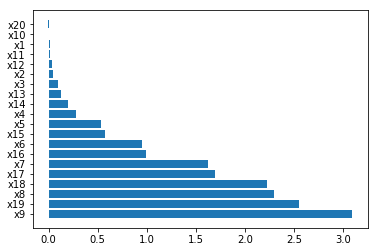

In [23]:
plt.barh(y=np.arange(20), width=df_importance['error_diff'], tick_label=df_importance['col'])
plt.show()

Using this we can see what variables are important and what are not important. The scores on the x axis are not as meaningful as comparing each variable to each other. We can see here that the features ranked by error difference is in the order that we would have expected. Although there is some variation.